In [28]:
import pandas as pd
import sqlite3
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

DB_PATH = "../../datasets/CCSMLDatabase.db"
TABLE = "master_clean"

conn = sqlite3.connect(DB_PATH)
df = pd.read_sql_query(
    f"SELECT * FROM master_clean",
    conn,
)
conn.close()

# Global style settings
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"], # Standard crisp fonts
    "axes.linewidth": 1.5,               # Thicker axis lines
    "axes.spines.top": False,            # Remove top spine
    "axes.spines.right": False,          # Remove right spine
    "xtick.major.width": 1.5,            # Match tick thickness to axis
    "ytick.major.width": 1.5,
    "xtick.direction": "out",            # Ticks point outside
    "ytick.direction": "out",
    "font.size": 10,
    "axes.labelsize": 11,
    "axes.labelweight": "normal",
})

n = df.shape[0] 
df.columns

Index(['id', 'tag', 'name', 'pubchemId', 'adduct', 'mass', 'z', 'ccs', 'smi',
       'inchikey', 'superclass', 'class', 'subclass'],
      dtype='object')

# Bar chart of data source percentages

/var/folders/qw/xxtxsrpx2vs33wbzwym6vf680000gn/T/ipykernel_13412/1666679167.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tag_perc.index, rotation=45, ha="right", fontsize=9)


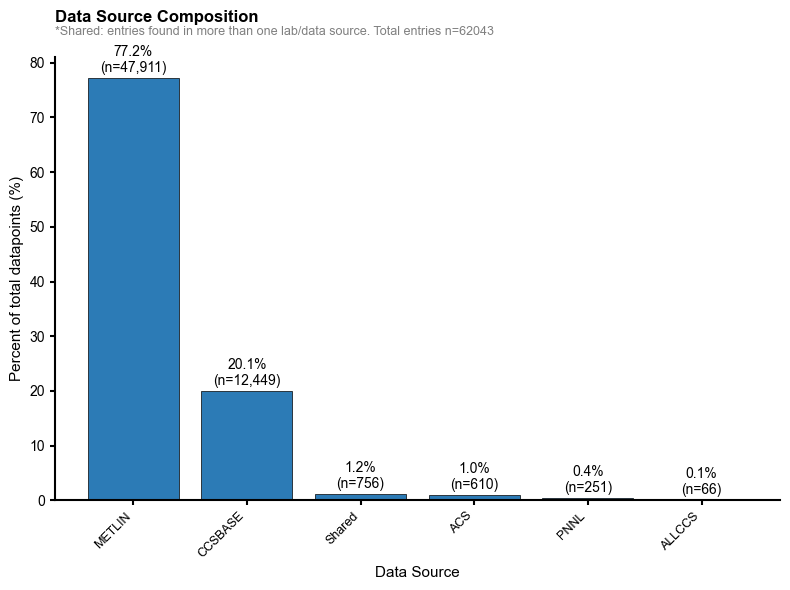

In [30]:
# Create a new column: if tag contains comma, label as "Shared", otherwise keep original
df_source = df.copy()
df_source["source_label"] = df_source["tag"].apply(
    lambda x: "Shared" if "," in str(x) else x
)

# Count entries per source label
tag_counts = df_source["source_label"].value_counts()
tag_perc = (tag_counts / tag_counts.sum()) * 100

# Sort by percentage descending
tag_perc = tag_perc.sort_values(ascending=False)
tag_counts = tag_counts[tag_perc.index]

fig, ax = plt.subplots(figsize=(max(8, 0.5 * len(tag_perc)), 6))
bars = ax.bar(tag_perc.index, tag_perc.values, color='#2c7bb6', edgecolor='black', linewidth=0.5)

ax.set_ylabel("Percent of total datapoints (%)")
ax.set_xlabel("Data Source")
ax.set_title('Data Source Composition', fontweight='bold', loc='left', pad=25)
ax.text(0, 1.05, f'*Shared: entries found in more than one lab/data source. Total entries n={n}',
        transform=ax.transAxes, fontsize=9, color='gray')

# Add labels with both percentage and count
for bar, pct, count in zip(bars, tag_perc.values, tag_counts.values):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    ax.text(x, y + 0.5, f'{pct:.1f}%\n(n={count:,})', ha='center', va='bottom', fontsize=10)

ax.set_xticklabels(tag_perc.index, rotation=45, ha="right", fontsize=9)

plt.tight_layout()
plt.show()

# CCS box/whisker plots by source 

/var/folders/qw/xxtxsrpx2vs33wbzwym6vf680000gn/T/ipykernel_13412/3134608066.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=False)


Text(0.5, 0, 'Dataset')

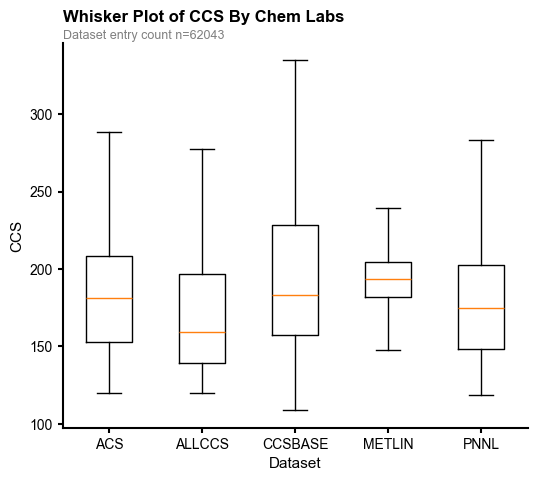

In [23]:
# split comma-delimited tags and duplicate rows
df["tag"] = df["tag"].str.split(",")
df = df.explode("tag")
df["tag"] = df["tag"].str.strip()

# prepare data + counts for plotting
tags = sorted(df["tag"].unique().tolist())
data = []
labels = []

for t in tags:
    vals = df.loc[df["tag"] == t, "ccs"].values
    data.append(vals)
    labels.append(f"{t}")


fig, ax = plt.subplots(figsize=(6, 5))

# box + whisker plots
ax.boxplot(data, labels=labels, showfliers=False)

ax.set_title('Whisker Plot of CCS By Chem Labs', fontweight='bold', loc='left', pad=15)                                                                
ax.text(0, 1.01, f'Dataset entry count n={n}',                                                                         
        transform=ax.transAxes, fontsize=9, color='gray')    


ax.set_ylabel("CCS")
ax.set_xlabel("Dataset")

# Summary table of datasets from each Chem Lab

Text(0.0, 1.0, 'Summary Statistics by Data Source')

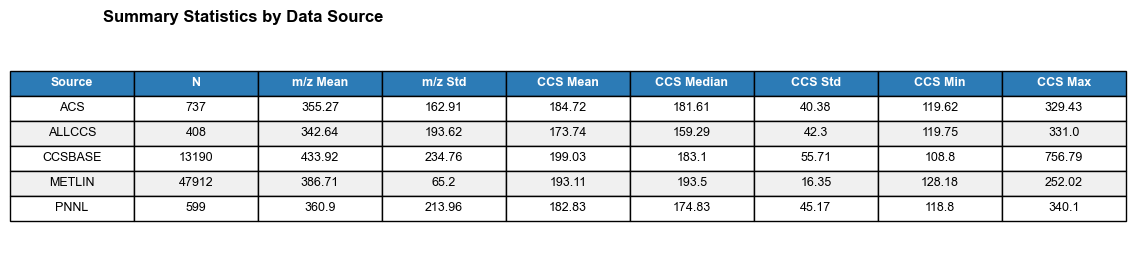

In [24]:
# Create summary dataframe                                                                                                          
summary = df.groupby('tag').agg(                                                                                                    
    N=('ccs', 'count'),                                                                                                             
    **{'m/z Mean': ('mass', 'mean')},                                                                                               
    **{'m/z Std': ('mass', 'std')},                                                                                                 
    **{'CCS Mean': ('ccs', 'mean')},                                                                                                
    **{'CCS Median': ('ccs', 'median')},                                                                                            
    **{'CCS Std': ('ccs', 'std')},                                                                                                  
    **{'CCS Min': ('ccs', 'min')},                                                                                                  
    **{'CCS Max': ('ccs', 'max')}                                                                                                   
).round(2)                                                                                                                          
                                                                                                                                    
summary = summary.reset_index().rename(columns={'tag': 'Source'})                                                                   
                                                                                                                                    
# Create table figure                                                                                                               
fig, ax = plt.subplots(figsize=(12, len(summary) * 0.4 + 1))                                                                        
ax.axis('off')                                                                                                                      
                                                                                                                                    
table = ax.table(                                                                                                                   
    cellText=summary.values,                                                                                                        
    colLabels=summary.columns,                                                                                                      
    loc='center',                                                                                                                   
    cellLoc='center'                                                                                                                
)                                                                                                                                   
                                                                                                                                    
# Style the table                                                                                                                   
table.auto_set_font_size(False)                                                                                                     
table.set_fontsize(9)                                                                                                               
table.scale(1.2, 1.5)                                                                                                               
                                                                                                                                    
# Header styling                                                                                                                    
for i in range(len(summary.columns)):                                                                                               
    table[(0, i)].set_facecolor('#2c7bb6')                                                                                          
    table[(0, i)].set_text_props(color='white', fontweight='bold')                                                                  
                                                                                                                                    
# Alternate row colors (optional)                                                                                                   
for i in range(1, len(summary) + 1):                                                                                                
    for j in range(len(summary.columns)):                                                                                           
        if i % 2 == 0:                                                                                                              
            table[(i, j)].set_facecolor('#f0f0f0')                                                                                  
                                                                                                                                    
ax.set_title('Summary Statistics by Data Source', fontweight='bold', loc='left')                                            
            